In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time, os, sys, gc

import svgutils.transform as sg 

import scipy
from scipy.interpolate import RegularGridInterpolator

import h5py 

import class_energy as energy

import class_handle_input as h_in
import class_handle_wavefunctions as h_wavef

import class_visualization as vis
import class_mass_size as mass_size

## Functions for plotting, IO and time propagation

First: a function that allows quick plotting of wavefunctions

In [3]:
def plot_rotor_wavefunction(x, chosen_My, chosen_Mx, psi):
    A = 6
    plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
    ##plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    #plt.rc('text.latex', preambler=r'\usepackage{textgreek}')
    font_size = 18 

    fig, axs = plt.subplots(chosen_My,chosen_Mx, subplot_kw=dict(polar=True))
    #plt.suptitle(r'$V_0 =$'+str(V_0), fontsize=font_size)

    for i in range(chosen_My):
         for j in range(chosen_Mx):
            axs[i, j].plot(x, psi[(i+int(chosen_My/2))%chosen_My,(j+int(chosen_My/2))%chosen_My], color='lightcoral')

            axs[i, j].set_yticklabels([])
            axs[i, j].set_xticklabels([])
            axs[i, j].set_theta_zero_location('E')

            axs[i, j].grid(linewidth=0.5)
            axs[i, j].spines['polar'].set_linewidth(0.3) #.set_visible(False)

    #axs[0, 0].set_theta_zero_location('E')
    #lines, labels = axs[0, 0].set_thetagrids((0, 45, 90, 135, 180), (r'0', ' ', r'$\pi/2$', ' ', r'$\pi$'))

In [4]:
def get_tx_ty(sum, diff):
    '''  
    Return tx and ty tunneling rates
    '''
    tx = 0.5*(sum+diff)
    ty = 0.5*(sum-diff)
    return tx, ty

## Define Calculation Parameters

In [5]:
params = {"n": 256,
"M": 36,
"Mx": 6,
"Mx_display": 4,
"converge_new_lattice": "no",
"My": 6,
"My_display": 4,
"B": 1.0,
"tx": 100,
"ty": 100,
"V_0": 150.0,
"qx": 0,
"qy": 0,
"init_choice": "ferro_domain_vertical_wall",
"external_wf_tag": " ",
"excitation_no": 11,
"angle_pattern": [0,0,0,0],
"V_0_pattern": [150,150,150,150],
"n_states": 0,
"path_to_input_wavefunction": " ",
"dt": 0.001,
"tol": 1e-9}

x = (2*np.pi/params["n"])*np.arange(params["n"])

Mx = params["Mx"]
My = params["My"]

n = params["n"]

tx = params["tx"]
ty = params["ty"]

B = params["B"]
V_0 = params["V_0"]

scale = B 


''' 
I/O Object
'''
h5_io_object = h_in.io_hdf5()

Scan specifications

In [19]:
sum_tx_ty = 200

V_0_arr_fo = np.arange(0,355,5)
V_0_arr_fdv = np.arange(0,355,5)
V_0_arr_fdh = np.arange(0,355,5)
V_0_arr_sp = np.arange(0,355,5)

V_0_arr = np.arange(0,355,5)

diff_tx_ty_fo = np.array([-200,-175,-150,-125,-100,-75,-50,-25,-1,1,25,50,75,100,125,150,175,200])
diff_tx_ty_fdh = np.array([-200,-175,-150,-125,-100,-75,-50,-25,-1,1,25,50,75,100,125,150,175,200])
diff_tx_ty_fdv = np.array([-200,-175,-150,-125,-100,-75,-50,-25,-1,1,25,50,75,100,125,150,175,200])
diff_tx_ty_sp = np.array([-200,-175,-150,-125,-100,-75,-50,-25,-1,1,25,50,75,100,125,150,175,200])

diff_tx_ty = np.array([-200,-175,-150,-125,-100,-75,-50,-25,-1,1,25,50,75,100,125,150,175,200])

In [7]:
def get_psi_properties(file_path, check_size, check_sym):
    h5_io_object = h_in.io_hdf5()
    file_list = [f for f in os.listdir(file_path) if check_size in f and check_sym in f]

    V_0_arr = np.zeros(len(file_list), dtype=complex)

    E_arr = np.zeros(len(file_list), dtype=complex)
    B_arr = np.zeros(len(file_list), dtype=complex)
    V_arr = np.zeros(len(file_list), dtype=complex)
    Tx_arr = np.zeros(len(file_list), dtype=complex)
    Ty_arr = np.zeros(len(file_list), dtype=complex)

    i = 0
    for file in file_list:
        psi, params = h5_io_object.get_psi(file_path+file)

        energy_object = energy.energy(params=params)

        E = energy_object.calc_energy(psi) # in form [E, E_T, E_B, E_V]
        Tx, Ty = energy_object.deriv_dE_dt(psi)

        E_arr[i] = E[0]
        B_arr[i] = E[2]
        V_arr[i] = E[3]
        Ty_arr[i] = Ty
        Tx_arr[i] = Tx

        V_0_arr[i] = params['V_0']

        i += 1

    index_sort = np.argsort(V_0_arr)

    V_0_arr = V_0_arr[index_sort]

    E_arr = E_arr[index_sort]
    B_arr = B_arr[index_sort]
    V_arr = V_arr[index_sort]
    Tx_arr = Tx_arr[index_sort]
    Ty_arr = Ty_arr[index_sort]

    return V_0_arr, E_arr, B_arr, V_arr, Tx_arr, Ty_arr

In [8]:
def get_e_arr(check_size, sum_tx_ty, diff_tx_ty, file_path):
    V_0_order = []
    E_order = []
    B_order = []
    V_order = []
    Tx_order = []
    Ty_order = []
    for j in range(len(diff_tx_ty)):
        tx, ty = get_tx_ty(sum_tx_ty, diff_tx_ty[j])

        check_sym  = 'tx_'+str(tx)+'_ty_'+str(ty)
        
        V_0_list, E_arr, B_arr, V_arr, Tx_arr, Ty_arr = get_psi_properties(file_path, check_size, check_sym)

        V_0_order.append(V_0_list)
        E_order.append(E_arr)
        B_order.append(B_arr)
        V_order.append(V_arr)
        Tx_order.append(Tx_arr)
        Ty_order.append(Ty_arr)
    
    V_0_order = np.array([x for x in V_0_order])
    E_order = np.array([x for x in E_order])
    B_order = np.array([x for x in B_order])
    V_order = np.array([x for x in V_order])
    Tx_order = np.array([x for x in Tx_order])
    Ty_order = np.array([x for x in Ty_order])

    return V_0_order, E_order, Tx_order, Ty_order

### Read in calculation results

In [16]:
''' 
FO Results
'''
check_size = '_B_1.0_Mx_8_My_8'
file_path = 'results/phase_diagram/fo/'

print('Reading results from FO calculations - please wait!')
V_0_arr_fo, E_fo_orig, Tx_fo_orig, Ty_fo_orig = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_fo, file_path)

''' 
FDh Results
'''
check_size = '_B_1.0_Mx_32_My_4'
file_path = 'results/phase_diagram/fdh/'

print('Reading results from FDh calculations - please wait!')
V_0_arr_fdh, E_fdh_orig, Tx_fdh_orig, Ty_fdh_orig = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_fdh, file_path)

''' 
FDv Results
'''
check_size = '_B_1.0_Mx_4_My_32'
file_path = 'results/phase_diagram/fdv/'

print('Reading results from FDh calculations - please wait!')
V_0_arr_fdv, E_fdv_orig, Tx_fdv_orig, Ty_fdv_orig = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_fdv, file_path)

''' 
SP Results
'''
check_size = 'Mx_8_My_8'
file_path = 'results/phase_diagram/sp/'

print('Reading results from SP calculations - please wait!')
V_0_arr_sp, E_sp_orig, Tx_sp_orig, Ty_sp_orig = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_sp, file_path)

Reading results from FO calculations - please wait!
Reading results from FDh calculations - please wait!
Reading results from FDh calculations - please wait!
Reading results from SP calculations - please wait!


Filter out the energies which don't correspond to the respective state and set the respective energies to zero. This helps in the further analysis.

In [17]:
def clean_phase(E_arr, Tx, Ty, phase):
    E_arr_n = np.zeros(E_arr.shape, dtype=complex)
    Tx_n = np.zeros(E_arr.shape, dtype=complex)
    Ty_n = np.zeros(E_arr.shape, dtype=complex)

    for i in range(E_arr.shape[0]):
        for j in range(E_arr.shape[1]):
            if phase == 'fo':
                if Tx[i,j] > 0.1 and Ty[i,j] > 0.1:
                    E_arr_n[i,j] = E_arr[i,j]
                    Tx_n[i,j] = Tx[i,j]
                    Ty_n[i,j] = Ty[i,j]
            elif phase == 'fdv':
                if Ty[i,j] > 0.5 and Tx[i,j] < 0.1:
                    E_arr_n[i,j] = E_arr[i,j]
                    Tx_n[i,j] = Tx[i,j]
                    Ty_n[i,j] = Ty[i,j]
            elif phase == 'fdh':
                if Tx[i,j] > 0.5 and Ty[i,j] < 0.1:
                    E_arr_n[i,j] = E_arr[i,j]
                    Tx_n[i,j] = Tx[i,j]
                    Ty_n[i,j] = Ty[i,j]
            elif phase == 'sp':
                if Ty[i,j] < 0.1 and Tx[i,j] < 0.1:
                    E_arr_n[i,j] = E_arr[i,j]
                    Tx_n[i,j] = Tx[i,j]
                    Ty_n[i,j] = Ty[i,j] 
    return E_arr_n, Tx_n, Ty_n
    
E_fo, Tx_fo, Ty_fo = clean_phase(E_fo_orig, np.abs(Tx_fo_orig), np.abs(Ty_fo_orig), 'fo')
E_fdv, Tx_fdv, Ty_fdv = clean_phase(E_fdv_orig, np.abs(Tx_fdv_orig), np.abs(Ty_fdv_orig), 'fdv')
E_fdh, Tx_fdh, Ty_fdh = clean_phase(E_fdh_orig, np.abs(Tx_fdh_orig), np.abs(Ty_fdh_orig), 'fdh')
E_sp, Tx_sp, Ty_sp = clean_phase(E_sp_orig, np.abs(Tx_sp_orig), np.abs(Ty_sp_orig), 'sp')

'''
This are manual correction!!
'''
E_fdv[0][0] = -400.0
E_fdv[0][1] = 0.5*(-400+E_fdv[0][2])

E_fdh[17][1] = 0.5*(-400+E_fdv[0][2])
E_fdh[17][0] = -400

Now we can determine the minimum energy at the respective coupling and symmetry points.

In [20]:
def get_gs_props(E_arr_fo, E_arr_fdv, E_arr_fdh, E_arr_sp, 
                 Tx_fo, Ty_fo, Tx_fdv, Ty_fdv, Tx_fdh, Ty_fdh, Tx_sp, Ty_sp):
    state_no = 0

    E_gs = np.zeros(E_arr_fo.shape, dtype=complex)
    Tx_order = np.zeros(E_arr_fo.shape, dtype=complex)
    Ty_order = np.zeros(E_arr_fo.shape, dtype=complex)

    for i in range(len(diff_tx_ty)):
        for j in range(len(V_0_arr)):
            E_fo  = E_arr_fo[i,j].real
            E_fdv = E_arr_fdv[i,j].real
            E_fdh = E_arr_fdh[i,j].real
            E_sp  = E_arr_sp[i,j].real

            Tx_fo_s  = Tx_fo[i,j]
            Tx_fdv_s = Tx_fdv[i,j]
            Tx_fdh_s = Tx_fdh[i,j]
            Tx_sp_s  = Tx_sp[i,j]

            Ty_fo_s  = Ty_fo[i,j]
            Ty_fdv_s = Ty_fdv[i,j]
            Ty_fdh_s = Ty_fdh[i,j]
            Ty_sp_s  = Ty_sp[i,j]

            E_arr  = np.array([E_fo,E_fdv,E_fdh,E_sp])
            Tx_arr = np.array([Tx_fo_s,Tx_fdv_s,Tx_fdh_s,Tx_sp_s])
            Ty_arr = np.array([Ty_fo_s,Ty_fdv_s,Ty_fdh_s,Ty_sp_s])

            E_index = np.argsort(E_arr)

            E_arr  = E_arr[E_index]
            Tx_arr = Tx_arr[E_index]
            Ty_arr = Ty_arr[E_index]
        
            E_gs[i,j] = E_arr[state_no]
            Tx_order[i,j] = Tx_arr[state_no]
            Ty_order[i,j] = Ty_arr[state_no]
    return E_gs, Tx_order, Ty_order

E_gs, Tx_order, Ty_order = get_gs_props(E_fo, E_fdv, E_fdh, E_sp, Tx_fo, Ty_fo, Tx_fdv, Ty_fdv, Tx_fdh, Ty_fdh, Tx_sp, Ty_sp)

Now we can interpolate the data.

In [24]:
def interpolate_data(x, y, data):
    f = scipy.interpolate.RegularGridInterpolator((x.real, y.real), data.real)
    
    Xnew = np.linspace(x[0].real, x[-1].real, 300)
    Ynew = np.linspace(y[0].real, y[-1].real, 300)
    Xnew, Ynew = np.meshgrid(Xnew, Ynew, indexing='ij')

    data_new = f((Xnew,Ynew), method='linear')
    return Xnew, Ynew, data_new

X_intp_fo, Y_intp_fo, E_fo_interp = interpolate_data(diff_tx_ty_fo, V_0_arr_fo.real, E_fo.real)
X_intp_fdv, Y_intp_fdv, E_fdv_interp = interpolate_data(diff_tx_ty_fdv, V_0_arr_fdv.real, E_fdv.real)
X_intp_fdh, Y_intp_fdh, E_fdh_interp = interpolate_data(diff_tx_ty_fdh, V_0_arr_fdh.real, E_fdh.real)
X_intp_sp, Y_intp_sp, E_sp_interp = interpolate_data(diff_tx_ty_sp, V_0_arr_sp.real, E_sp.real)

X_intp, Y_intp, Tx_fo_interp = interpolate_data(diff_tx_ty, V_0_arr_fo.real, Tx_fo.real)
X_intp, Y_intp, Tx_fdv_interp = interpolate_data(diff_tx_ty, V_0_arr_fdv.real, Tx_fdv.real)
X_intp, Y_intp, Tx_fdh_interp = interpolate_data(diff_tx_ty, V_0_arr_fdh.real, Tx_fdh.real)
X_intp, Y_intp, Tx_sp_interp = interpolate_data(diff_tx_ty, V_0_arr_sp.real, Tx_sp.real)

X_intp, Y_intp, Ty_fo_interp = interpolate_data(diff_tx_ty, V_0_arr_fo.real, Ty_fo.real)
X_intp, Y_intp, Ty_fdv_interp = interpolate_data(diff_tx_ty, V_0_arr_fdv.real, Ty_fdv.real)
X_intp, Y_intp, Ty_fdh_interp = interpolate_data(diff_tx_ty, V_0_arr_fdh.real, Ty_fdh.real)
X_intp, Y_intp, Ty_sp_interp = interpolate_data(diff_tx_ty, V_0_arr_sp.real, Ty_sp.real)

E_gs_int = np.zeros(E_fo_interp.shape)
Tx_gs_int = np.zeros(E_fo_interp.shape)
Ty_gs_int = np.zeros(E_fo_interp.shape)
for i in range(len(X_intp_fo.T)):
    for j in range(len(X_intp_fo)):
        E_arr = np.array([E_fo_interp[i,j],E_fdv_interp[i,j],E_fdh_interp[i,j],E_sp_interp[i,j]])
        Tx_arr = np.array([Tx_fo_interp[i,j],Tx_fdv_interp[i,j],Tx_fdh_interp[i,j],Tx_sp_interp[i,j]])
        Ty_arr = np.array([Ty_fo_interp[i,j],Ty_fdv_interp[i,j],Ty_fdh_interp[i,j],Ty_sp_interp[i,j]])
        
        E_index = np.argsort(E_arr)
        
        E_arr = E_arr[E_index]
        Tx_arr = Tx_arr[E_index]
        Ty_arr = Ty_arr[E_index]
        
        E_gs_int[i,j] = E_arr[0].real
        Tx_gs_int[i,j] = Tx_arr[0].real #np.max(Tx_arr).real
        Ty_gs_int[i,j] = Ty_arr[0].real #np.max(Ty_arr).real

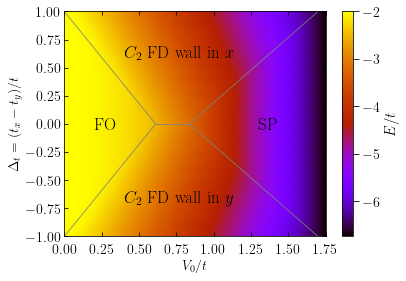

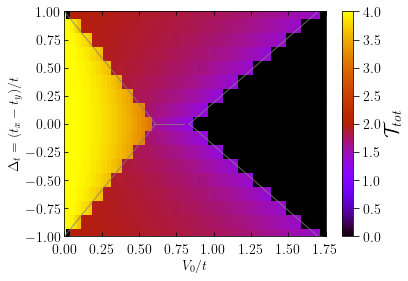

In [77]:
t = 200
X, Y = np.meshgrid(V_0_arr.real, diff_tx_ty.real)

#X_intp1, Y_intp1, E_gs_interp = interpolate_data(diff_tx_ty, V_0_arr[0].real, E_gs.real)

A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 14

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)]) #, subplot_kw={"projection": "3d"})
#ax.set_aspect("equal")

#pc = plt.pcolormesh(X,Y,E_gs.real, linewidth=0.)
pc = ax.pcolormesh(X/t, Y/t, E_gs.real/t, antialiased=False, cmap='gnuplot', shading='gouraud')

cbar = fig.colorbar(pc) #, orientation="horizontal", pad=0.2)
cbar.ax.tick_params(length=6, labelsize=font_size)
cbar.set_label(label=r'$E/t$', size=15)
cbar.solids.set_rasterized(True)
pc.set_edgecolor('face')

plt.plot(np.array([0,0.612]), np.array([1,0]), linestyle='solid', color='grey', linewidth=1, alpha=0.8)
plt.plot(np.array([0,0.612]), np.array([-1,0]), linestyle='solid', color='grey', linewidth=1, alpha=0.8)
plt.plot(np.array([0.8375,1.7]), np.array([0,1]), linestyle='solid', color='grey', linewidth=1, alpha=0.8)
plt.plot(np.array([0.8375,1.7]), np.array([0,-1]), linestyle='solid', color='grey', linewidth=1, alpha=0.8)
plt.plot(np.array([0.612,0.8375]), np.array([0,0]), linestyle='solid', color='grey', linewidth=1, alpha=0.8)

#ax.annotate(r'a)', xy=(0.2, -0.1), xytext=(-0.5, 0.9), fontsize=25, color='black')

ax.annotate(r'FO', xy=(0.2, -0.1), xytext=(0.2, -0.051), fontsize=17, color='black')
ax.annotate(r'$C_2$ FD wall in $x$', xy=(0.2, 0), xytext=(0.4, 0.6), fontsize=17, color='black')
ax.annotate(r'$C_2$ FD wall in $y$', xy=(0.2, 0), xytext=(0.4, -0.7), fontsize=17, color='black')
ax.annotate(r'SP', xy=(0.2, -0.1), xytext=(1.3, -0.051), fontsize=17, color='black')

plt.xlim(0,V_0_arr[-1].real/t)
plt.ylim(-1,1)

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$\Delta_t = (t_x-t_y)/t$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True, pad=7)
plt.tick_params(axis='y', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.savefig('results/phase_diagram/energies_B_1.0.pdf', bbox_inches='tight', dpi=50)
plt.show()


#X_intp, Y_intp, order_p_interp = interpolate_data(diff_tx_ty, V_0_arr[0], order_p.real)

fig = plt.figure()

pc = plt.pcolormesh(X/t, Y/t, np.abs(Tx_order+Ty_order), shading='auto', cmap='gnuplot')

cbar = fig.colorbar(pc)
cbar.ax.tick_params(length=6, labelsize=font_size)
cbar.set_label(label=r'$\mathcal{T}_{tot}$', size=20)

plt.plot(np.array([0,0.612]), np.array([1,0]), linestyle='solid', color='grey', linewidth=1, alpha=0.8)
plt.plot(np.array([0,0.612]), np.array([-1,0]), linestyle='solid', color='grey', linewidth=1, alpha=0.8)
plt.plot(np.array([0.8375,1.7]), np.array([0,1]), linestyle='solid', color='grey', linewidth=1, alpha=0.8)
plt.plot(np.array([0.8375,1.7]), np.array([0,-1]), linestyle='solid', color='grey', linewidth=1, alpha=0.8)
plt.plot(np.array([0.6,0.8]), np.array([0,0]), linestyle='solid', color='grey', linewidth=1, alpha=0.8)

plt.xlim(0,V_0_arr[-1].real/t)
plt.ylim(-1,1)

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$\Delta_t = (t_x-t_y)/t$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True, pad=7)
plt.tick_params(axis='y', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.show()

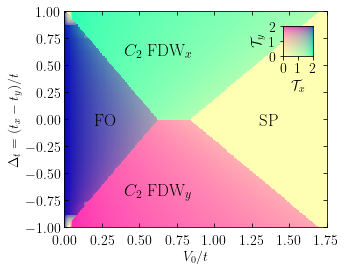

In [80]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 14

fig, ax = plt.subplots(figsize=[53 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
#ax.set_aspect("equal")

y = np.linspace(diff_tx_ty[0].real, diff_tx_ty[-1].real, 300)/200 
x = np.linspace(V_0_arr[0].real, V_0_arr[-1].real, 300)/t 

'''
A very simple colormap:
#  mapping parameter 1 to the red channel and 
#          parameter 2 to the blue channel
'''
green_frac = 0.7
cmap = lambda p1,p2 : ((1-np.abs(p1/2))**(1/3), (1-np.abs(p2/2))**(1/3), green_frac)


p1 = Tx_fdv_interp 
p2 = Ty_fdv_interp 
for j in range(len(y)):
    x_int1 = 0.612*(y[j]+1)
    x_int2 = -(1.7-0.8375)*y[j] + 0.8375
    for i in range(len(x)):
        if x[i] > x_int1 and x[i] < x_int2 and y[j] < 0:
            circle = matplotlib.patches.Rectangle((x[i], y[j]), 0.006, 0.006, color=cmap(p1[j,i],p2[j,i]))
            ax.add_artist(circle)

p1 = Tx_fdh_interp
p2 = Ty_fdh_interp 
for j in range(len(y)):
    x_int1 = -0.612*(y[j]-1)
    x_int2 = (1.7-0.8375)*y[j] + 0.8375
    for i in range(len(x)):
        if x[i] > x_int1 and x[i] < x_int2 and y[j] > 0:
            circle = matplotlib.patches.Rectangle((x[i], y[j]), 0.006, 0.006, color=cmap(p1[j,i],p2[j,i]))
            ax.add_artist(circle)

p1 = Tx_fo_interp 
p2 = Ty_fo_interp 
for j in range(len(y)):
    x_int1 = 0.612*(y[j]+1)
    x_int2 = -0.612*(y[j]-1)
    for i in range(len(x)):
        if x[i] < x_int1 and x[i] < x_int2:
            circle = matplotlib.patches.Rectangle((x[i], y[j]), 0.006, 0.006, color=cmap(p1[j,i],p2[j,i]))
            ax.add_artist(circle)
            
p1 = Tx_sp_interp 
p2 = Ty_sp_interp 
for j in range(len(y)):
    x_int1 = -(1.7-0.8375)*y[j] + 0.8375
    x_int2 = (1.7-0.8375)*y[j] + 0.8375
    for i in range(len(x)):
        if x[i] > x_int1 and x[i] > x_int2:
            circle = matplotlib.patches.Rectangle((x[i], y[j]), 0.006, 0.006, color=cmap(p1[j,i],p2[j,i]))
            ax.add_artist(circle)
            
#plt.plot(np.array([0,0.612]), np.array([1,0]), linestyle='dashed', color='grey', linewidth=4, alpha=1)
#plt.plot(np.array([0,0.612]), np.array([-1,0]), linestyle='dashed', color='grey', linewidth=4, alpha=1)
#plt.plot(np.array([0.8375,1.7]), np.array([0,1]), linestyle='dashed', color='grey', linewidth=4, alpha=1)
#plt.plot(np.array([0.8375,1.7]), np.array([0,-1]), linestyle='dashed', color='grey', linewidth=4, alpha=1)
#plt.plot(np.array([0.612,0.8375]), np.array([0,0]), linestyle='dashed', color='grey', linewidth=4, alpha=1)

#ax.annotate(r'b)', xy=(0.2, -0.1), xytext=(-0.5, 1.5), fontsize=25, color='black')

ax.annotate(r'FO', xy=(0.2, -0.1), xytext=(0.2, -0.051), fontsize=17, color='black')
ax.annotate(r'$C_2$ FDW$_x$', xy=(0.2, 0), xytext=(0.4, 0.6), fontsize=17, color='black')
ax.annotate(r'$C_2$ FDW$_y$', xy=(0.2, 0), xytext=(0.4, -0.7), fontsize=17, color='black')
ax.annotate(r'SP', xy=(0.2, -0.1), xytext=(1.3, -0.051), fontsize=17, color='black')

plt.xlim(0,1.75)
plt.ylim(-1,1)

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$\Delta_t = (t_x-t_y)/t$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True, pad=7)
plt.tick_params(axis='y', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.subplots_adjust(left=0.1, right=0.65, top=0.85)
cax = fig.add_axes([0.54,0.7,0.1,0.1]) #fig.add_axes([0.72,0.55,0.3,0.3])
cp1 = np.linspace(0, 1, 100)
cp2 = np.linspace(0, 1, 100)
Cp1, Cp2 = np.meshgrid(cp1,cp2)
C0 = green_frac*np.ones_like(Cp2)
# make RGB image, p1 to red channel, p2 to blue channel
Legend = np.dstack(((1-Cp1)**(1/3),(1-Cp2)**(1/3),C0))

# parameters range between 0 and 1
cax.imshow(Legend, origin="lower", extent=[0,2,0,2])
cax.set_xticks([0,1,2], [r'0',r'1',r'2'], fontsize=font_size)
cax.set_yticks([0,1,2], [r'0',r'1',r'2'], fontsize=font_size)
cax.set_xlabel(r'$\mathcal{T}_x$', fontsize=font_size)
cax.set_ylabel(r'$\mathcal{T}_y$', fontsize=font_size)
#cax.set_title("2D cmap legend", fontsize=10)

plt.savefig('results/phase_diagram/order_parameters_B_1.0.pdf', bbox_inches='tight', dpi=50)
plt.show()

In [488]:
import svgutils.transform as sg 

fig = sg.SVGFigure("16cm", "16cm")

fig1 = sg.fromfile('results/phase_diagram/energies_B_1.0.svg')
fig2 = sg.fromfile('results/phase_diagram/order_parameters_B_1.0.svg')

plot1 = fig1.getroot()
plot2 = fig2.getroot()

plot2.moveto(5,300)

txt1 = sg.TextElement(0,20, r"a)", size=20)
txt2 = sg.TextElement(0,330, r"b)", size=20) 

fig.append([plot1,plot2])
#fig.append([txt1,txt2])

fig.save('results/phase_diagram/phase_diagram_B_1.0.svg')

#### Comparison of FO for different symmetry realizations

The energies in the FO show a quadratic dependence on the coupling $V_0$. Here, we give an intuition for the dependence of the prefactor on the asymmetry $t_x-t_y$.

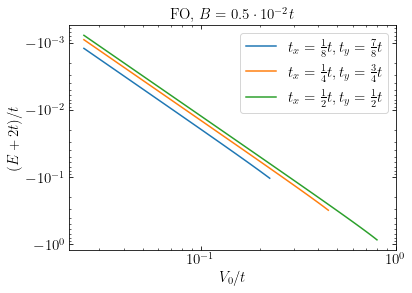

In [46]:
def get_non_zero(V, E):
    index_nonzero = np.where(E < 0)
    E_nonzero = E[index_nonzero]
    V_nonzero = V[index_nonzero]
    return V_nonzero, E_nonzero

V1, E1 = get_non_zero(V_0_arr_fo[1:], E_fo[2][1:])
V2, E2 = get_non_zero(V_0_arr_fo[1:], E_fo[4][1:])
V3, E3 = get_non_zero(V_0_arr_fo[1:], E_fo[5][1:])
V4, E4 = get_non_zero(V_0_arr_fo[1:], E_fo[8][1:])

A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 15

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)]) #, subplot_kw={"projection": "3d"})

plt.title(r'FO, $B=0.5\cdot 10^{-2}t$', fontsize=font_size)

plt.plot(V1.real/t, -(E1+2*t).real/t, label=r'$t_x=\frac{1}{8}t,t_y=\frac{7}{8}t$')
plt.plot(V2.real/t, -(E2+2*t).real/t, label=r'$t_x=\frac{1}{4}t,t_y=\frac{3}{4}t$')
plt.plot(V4.real/t, -(E4+2*t).real/t, label=r'$t_x=\frac{1}{2}t,t_y=\frac{1}{2}t$')

plt.xscale('log')
plt.yscale('log')

ax.invert_yaxis() 

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)

plt.xticks([1e-1,1e0], [r'$10^{-1}$',r'$10^{0}$'], fontsize=font_size)
plt.yticks([1e0,1e-1,1e-2,1e-3], [r'$-10^{0}$',r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$'], fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True)
plt.tick_params(axis='y', direction='in', length=4, right=True)
plt.tick_params(which='minor', axis='x', direction='in', top=True)
plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.legend(fontsize=font_size)
plt.savefig('results/phase_diagram/FO_comp.svg')

#### Convergence with lattice size in FO

Problem: the offset differences for the different asymmetry realizations in the FO might be due to finite size effects, i.e. in principle we would have to adapt the grid size when changing the ratio of $t_x$ and $t_y$. Here we compare the energies over the relevant coupling range for an asymmetric realization.

Reading results from FO calculations - please wait!
Reading results from FO calculations - please wait!

e-diff 8-32 = [0.00723851+4.27453245e-20j 0.02718064-6.89589135e-20j
 0.06134697-4.41209882e-19j 0.11288528-2.78433011e-19j
 0.18823972+8.01090669e-19j 0.29727177-8.71090888e-19j
 0.4546422 +8.87533937e-19j 0.68665368+1.76533063e-18j
 1.04976348-2.96653804e-18j]

e-diff 8-64 = [0.00723789+2.64281381e-20j 0.02717125+2.82037091e-20j
 0.06133304+1.66242667e-19j 0.11298363-6.68593454e-20j
 0.18859188+7.28312649e-20j 0.29809847-7.27514464e-19j
 0.45637228+3.58166816e-19j 0.68998839-4.37706768e-18j
 1.05541062-1.95759925e-18j]


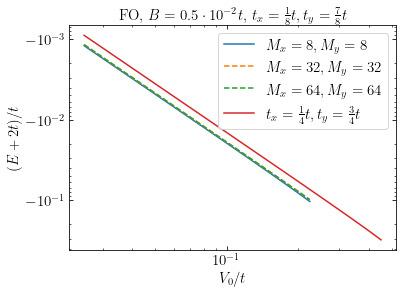

In [79]:
''' 
FO Results M=32*32
'''
check_size = '_B_1.0_Mx_32_My_32'
file_path = 'results/phase_diagram/fo/'

diff_tx_ty_fo_sys_check = np.array([150])

print('Reading results from FO calculations - please wait!')
V_0_arr_fo_check, E_fo_orig_check, Tx_fo_orig_check, Ty_fo_orig_check = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_fo_sys_check, file_path)


''' 
FO Results M=64*64
'''
check_size = '_B_1.0_Mx_64_My_64'
file_path = 'results/phase_diagram/fo/'

diff_tx_ty_fo_sys_check = np.array([150])

print('Reading results from FO calculations - please wait!')
V_0_arr_fo_check64, E_fo_orig_check64, Tx_fo_orig_check64, Ty_fo_orig_check64 = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_fo_sys_check, file_path)


diff_energies_fo_as = E_fo_orig_check[0]-E1
diff_energies_fo_as64 = E_fo_orig_check64[0]-E1

print('\ne-diff 8-32 =', diff_energies_fo_as)
print('\ne-diff 8-64 =', diff_energies_fo_as64)

plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 15

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)]) #, subplot_kw={"projection": "3d"})

plt.title(r'FO, $B=0.5\cdot 10^{-2}t$, $t_x=\frac{1}{8}t,t_y=\frac{7}{8}t$', fontsize=font_size)

plt.plot(V1.real/t, -(E1+2*t).real/t, label=r'$M_x=8,M_y=8$')
plt.plot(V_0_arr_fo_check[0].real/t, -(E_fo_orig_check[0]+2*t).real/t, linestyle='dashed', label=r'$M_x=32,M_y=32$')
plt.plot(V_0_arr_fo_check64[0].real/t, -(E_fo_orig_check64[0]+2*t).real/t, linestyle='dashed', label=r'$M_x=64,M_y=64$')

plt.plot(V2.real/t, -(E2+2*t).real/t, label=r'$t_x=\frac{1}{4}t,t_y=\frac{3}{4}t$')


plt.xscale('log')
plt.yscale('log')

ax.invert_yaxis() 

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks([1e-1,1e-2,1e-3], [r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$'], fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True)
plt.tick_params(axis='y', direction='in', length=4, right=True)
plt.tick_params(which='minor', axis='x', direction='in', top=True)
plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.legend(fontsize=font_size)

## Confirmation of FD domain existence for $t_x=t_y=0.5t$

The computation of the vGH energies shows significant finite-size dependence. Hence we compute the energies for big lattices where we are sure that the energies are converged (within ...). 

TODO: summary of how long the cluster computations took for this lattice system!

This experiment confirms the existence of the ferro-domains in the symmetric case.

In [69]:
diff_tx_ty_sym = np.array([0])

''' 
FO Results
'''
check_size = '_B_1.0_Mx_32_My_32_qx_0_qy_0'
file_path = 'results/phase_diagram/fo/'

print('Reading results from FO calculations - please wait!')
V_0_arr_sym, E_fo_sym, Tx_fo_sym, Ty_fo_sym = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_sym, file_path)


''' 
FDv Results
'''
check_size = '_B_1.0_Mx_4_My_256_qx_0_qy_0'
file_path = 'results/phase_diagram/fdv/'

print('Reading results from FDv calculations - please wait!')
V_0_arr_sym, E_fdv_sym, Tx_fdv_sym, Ty_fdv_sym = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_sym, file_path)


''' 
SP Results
'''
check_size = '_B_1.0_Mx_8_My_8_qx_0_qy_0'
file_path = 'results/phase_diagram/sp/'

print('Reading results from SP calculations - please wait!')
V_0_arr_sym, E_sp_sym, Tx_sp_sym, Ty_sp_sym = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_sym, file_path)

Reading results from FO calculations - please wait!
Reading results from FDv calculations - please wait!
Reading results from SP calculations - please wait!


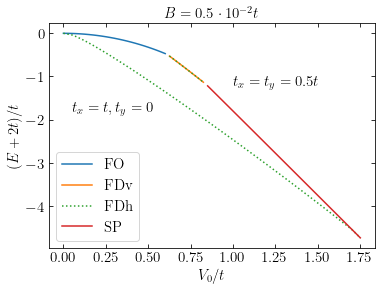

In [117]:
E_sym_fo_n, Tx_sym_fo_n, Ty_sym_fo_n = clean_phase(E_fo_sym, np.abs(Tx_fo_sym), np.abs(Ty_fo_sym), 'fo')
E_sym_fdv_n, Tx_sym_fdv_n, Ty_sym_fdv_n = clean_phase(E_fdv_sym, np.abs(Tx_fdv_sym), np.abs(Ty_fdv_sym), 'fdv')
E_sym_sp_n, Tx_sym_sp_n, Ty_sym_sp_n = clean_phase(E_sp_sym, np.abs(Tx_sp_sym), np.abs(Ty_sp_sym), 'sp')

def find_minimum_e(E1, E2, E3, E4, V_0_arr, arr_num):
    V_list = []
    E_list = []
    index_list = []
    for i in range(len(V_0_arr[0])):
        E_arr = np.array([E1[0,i],E2[0,i],E3[0,i],E4[0,i]])

        if E_arr[int(arr_num)] == np.min(E_arr):
            V_list.append(V_0_arr[0,i])
            E_list.append(E_arr[arr_num])
            index_list.append(i)

    return np.array(V_list), np.array(E_list), index_list

V_min_fo, E_min_fo, ind_list_fo = find_minimum_e(E_sym_fo_n, E_sym_fdv_n, E_sym_fdv_n, E_sym_sp_n, V_0_arr_sym, 0)
V_min_fdv, E_min_fdv, ind_list_fdv = find_minimum_e(E_sym_fo_n, E_sym_fdv_n, E_sym_fdv_n, E_sym_sp_n, V_0_arr_sym, 1)
V_min_sp, E_min_sp, ind_list_sp = find_minimum_e(E_sym_fo_n, E_sym_fdv_n, E_sym_fdv_n, E_sym_sp_n, V_0_arr_sym, 3)


A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 15

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)]) #, subplot_kw={"projection": "3d"})
#ax.set_aspect("equal")

plt.title(r'$B=0.5\cdot 10^{-2}t$', fontsize=font_size)

plt.plot(V_min_fo.real/t, E_min_fo.real/t+2, label=r'FO')
plt.plot(V_min_fdv.real/t, E_min_fdv.real/t+2, label=r'FDv')
plt.plot(V_min_fdv.real/t, E_min_fdv.real/t+2, linestyle='dotted', label=r'FDh')

plt.plot(V_0_arr.real.real/t, E_gs.real[0]/t+2, linestyle='dotted', color='tab:green')

plt.plot(V_min_sp.real[0:37]/t, E_min_sp.real[0:37]/t+2, label=r'SP')

#plt.vlines(0.612, ymin=np.min(E_min_sp.real[0:37]/t+2), ymax=1, linestyle='dashed', color='grey', alpha=0.8)
#plt.vlines(0.8375, ymin=np.min(E_min_sp.real[0:37]/t+2), ymax=1, linestyle='dashed', color='grey', alpha=0.8)

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)

ax.annotate(r'$t_x=t,t_y=0$', xy=(0.05, -1.5), xytext=(0.05, -1.8), fontsize=15, color='black')
ax.annotate(r'$t_x=t_y=0.5t$', xy=(0.8, -1.2), xytext=(1, -1.2), fontsize=15, color='black')

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True)
plt.tick_params(axis='y', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.legend(fontsize=font_size, loc=3)
plt.savefig('results/phase_diagram/vGH_energies_symmetric_asymmetric_comparison.svg', bbox_inches='tight', dpi=50)

/nfs/scistore12/lemesgrp/fkluiben/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


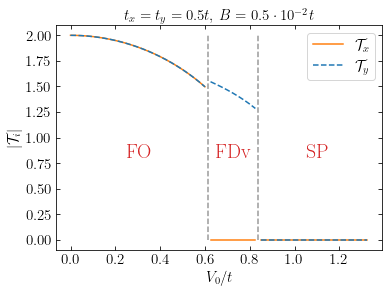

In [71]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 15

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)]) #, subplot_kw={"projection": "3d"})
#ax.set_aspect("equal")

plt.title(r'$t_x=t_y=0.5t$, $B=0.5\cdot 10^{-2}t$', fontsize=font_size)

plt.plot(V_min_fo/t, np.abs(Tx_fo_sym[0][ind_list_fo]), color='tab:orange', label=r'$\mathcal{T}_x$')
plt.plot(V_min_fo/t, np.abs(Ty_fo_sym[0][ind_list_fo]), color='tab:blue', linestyle='dashed', label=r'$\mathcal{T}_y$')

plt.plot(V_min_fdv/t, np.abs(Tx_fdv_sym[0][ind_list_fdv]), color='tab:orange')
plt.plot(V_min_fdv/t, np.abs(Ty_fdv_sym[0][ind_list_fdv]), color='tab:blue', linestyle='dashed')

plt.plot(V_min_sp[0:20]/t, np.abs(Tx_sp_sym[0][ind_list_sp])[0:20], color='tab:orange')
plt.plot(V_min_sp[0:20]/t, np.abs(Ty_sp_sym[0][ind_list_sp])[0:20], color='tab:blue', linestyle='dashed')

plt.vlines(0.612, ymin=0, ymax=2, linestyle='dashed', color='grey', alpha=0.8)
plt.vlines(0.8375, ymin=0, ymax=2, linestyle='dashed', color='grey', alpha=0.8)

ax.annotate(r'FO', xy=(0.25, 0.6), xytext=(0.25, 0.8), fontsize=20, color='tab:red')
ax.annotate(r'FDv', xy=(0.25, 0.6), xytext=(0.65, 0.8), fontsize=20, color='tab:red')
ax.annotate(r'SP', xy=(0.25, 0.6), xytext=(1.05, 0.8), fontsize=20, color='tab:red')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$|\mathcal{T}_i|$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True)
plt.tick_params(axis='y', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.legend(fontsize=font_size)

In [72]:
V_min_fo

array([  0.+0.j,   5.+0.j,  10.+0.j,  15.+0.j,  20.+0.j,  25.+0.j,
        30.+0.j,  35.+0.j,  40.+0.j,  45.+0.j,  50.+0.j,  55.+0.j,
        60.+0.j,  65.+0.j,  70.+0.j,  75.+0.j,  80.+0.j,  85.+0.j,
        90.+0.j,  95.+0.j, 100.+0.j, 105.+0.j, 110.+0.j, 115.+0.j,
       120.+0.j])

In [73]:
np.arange(5,125,5)

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120])